In [40]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Change working directory if needed
if not os.path.exists('data'):
    current_path = os.getcwd()
    root_path = os.path.abspath(os.path.join(current_path, '..'))
    os.chdir(root_path)
    print(f'Changed working directory to: {os.getcwd()}')

# Load daily data (adjust path if needed)
group_4_daily = pd.read_parquet('data/02_processed/parquet/group_4_daily.parquet')

In [41]:
# We'll use lagged consumption, day of week, month, and holiday as features
uk_bank_holidays = pd.read_csv('data/00_raw/uk_bank_holidays.csv')
uk_bank_holidays['Bank holidays'] = pd.to_datetime(uk_bank_holidays['Bank holidays'], format='mixed')
holiday_dates = set(uk_bank_holidays['Bank holidays'].dt.date)

df = group_4_daily.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['IsHoliday'] = df['Date'].dt.date.isin(holiday_dates).astype(int)
df['Lag1'] = df['Conso_kWh'].shift(1)
df['Lag7'] = df['Conso_kWh'].shift(7)
df = df.dropna().reset_index(drop=True)

In [42]:
# Train/Test Split
# Split for validation (last 30 days before test period)
validation_end = test_start - pd.Timedelta(days=1)
validation_start = validation_end - pd.Timedelta(days=29)

train_val = df[df['Date'] < validation_start]
validation = df[(df['Date'] >= validation_start) & (df['Date'] <= validation_end)]


feature_cols = ['Lag1', 'Lag7', 'DayOfWeek', 'Month', 'IsHoliday']
target_col = 'Conso_kWh'

X_train_val = train_val[feature_cols]
y_train_val = train_val[target_col]
X_val = validation[feature_cols]
y_val = validation[target_col]

In [43]:
# Model Training (Decision Tree Regressor example)
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error

model = DecisionTreeRegressor(max_depth=5, random_state=42)
model.fit(X_train_val, y_train_val)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [44]:
# Prediction and Evaluation
y_val_pred = model.predict(X_val)
val_rmse = root_mean_squared_error(y_val, y_val_pred)
print(f"Validation RMSE: {val_rmse:.2f} kWh")

Validation RMSE: 2.52 kWh


In [ ]:
# Define the test period for the real forecast
test_start = pd.Timestamp('2014-01-13')
test_end = pd.Timestamp('2014-02-13')

train = df[df['Date'] < test_start]
test = df[(df['Date'] >= test_start) & (df['Date'] <= test_end)]

X_train = train[feature_cols]
y_train = train[target_col]
X_test = test[feature_cols]
y_test = test[target_col]

# Retrain model on all data before test period
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
test_rmse = root_mean_squared_error(y_test, y_test_pred)
print(f"Test RMSE (forecast period): {test_rmse:.2f} kWh")

ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by DecisionTreeRegressor.

ValueError: x and y must have same first dimension, but have shapes (0,) and (90,)

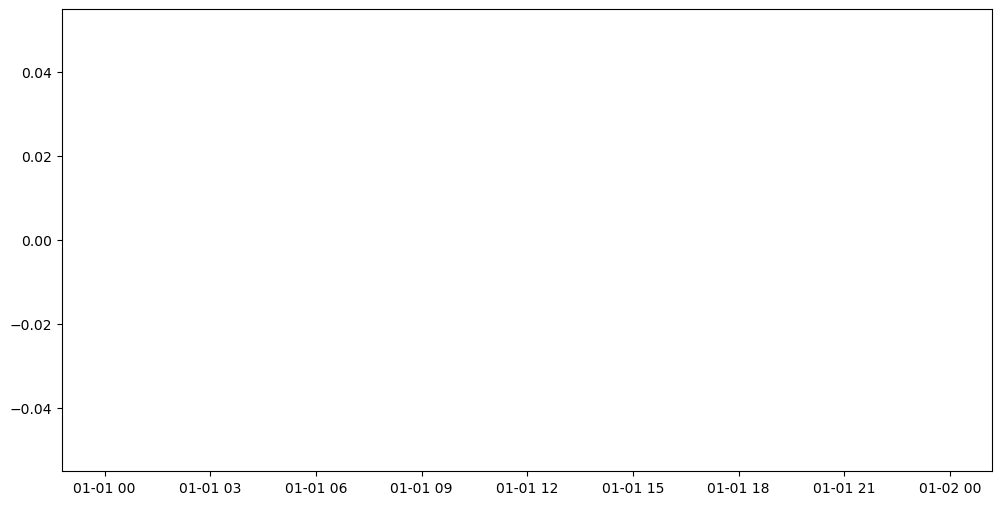

In [ ]:
# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], y_test.values, label='Actual', marker='o')
plt.plot(test['Date'], y_pred, label='Predicted', marker='x')
plt.title('Daily Consumption: Actual vs Predicted (Decision Tree)')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()